<a href="https://colab.research.google.com/github/delfinamoya06/finanzas-trabajo-practico-utn-2025/blob/main/Notebook_2_Analisis_de_cartera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  5 of 5 completed



--- Optimización de Portafolio (Simulación Monte Carlo) ---

--- Cartera con Máximo Sharpe Ratio ---
Return          0.082447
Volatility      0.163136
Sharpe Ratio    0.382793
Weight_KO       0.399765
Weight_PEP      0.074263
Weight_KDP      0.134895
Weight_MNST     0.391076
Name: 966, dtype: float64

--- Cartera de Mínimo Riesgo ---
Return          0.070792
Volatility      0.151708
Sharpe Ratio    0.334801
Weight_KO       0.391294
Weight_PEP      0.238730
Weight_KDP      0.275624
Weight_MNST     0.094352
Name: 11927, dtype: float64

--- Mi Elección Personal de Portfolio (8% de Retorno con Mínimo Riesgo) ---
Return          0.075076
Volatility      0.153159
Sharpe Ratio    0.359597
Weight_KO       0.399784
Weight_PEP      0.111974
Weight_KDP      0.306174
Weight_MNST     0.182068
Name: 8432, dtype: float64


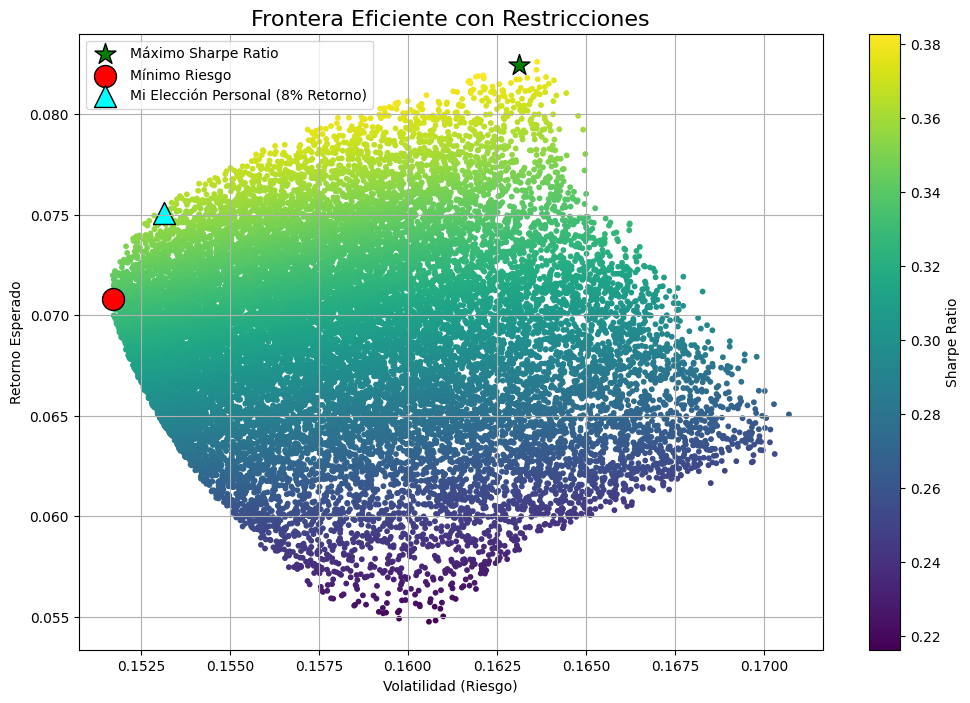

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los tickers y el período, si no se han definido antes
TICKERS_MAIN = ["KO", "PEP", "KDP", "MNST", "SPY"]
PERIOD = "5y"

# Función para obtener datos
def get_historical_data(tickers, period):
    try:
        prices = yf.download(tickers, period=period, auto_adjust=True)['Close']
        if prices.empty:
            raise ValueError("No se pudieron descargar datos para los tickers.")
        return prices
    except Exception as e:
        print(f"Error descargando datos: {e}")
        return None

# Función para calcular retornos
def daily_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

# --- LÓGICA PRINCIPAL ---

# Descargar datos y calcular retornos
prices_df = get_historical_data(TICKERS_MAIN, PERIOD)
rets = daily_returns(prices_df)

# OPTIMIZACIÓN DE PORTAFOLIO
print("\n--- Optimización de Portafolio (Simulación Monte Carlo) ---")

# Calcular retornos y covarianzas anualizadas
# Multiplicar por 252 para anualizar (días hábiles en un año)
annual_returns = rets.mean() * 252
cov_matrix_annual = rets.cov() * 252

# Definir la tasa libre de riesgo (ej. 2% anual)
risk_free_rate = 0.02

# Definir los activos para la optimización (excluyendo el benchmark)
assets_for_portfolio = [t for t in TICKERS_MAIN if t != "SPY"]
num_assets = len(assets_for_portfolio)
num_portfolios = 20000

# Arrays para almacenar los resultados de las simulaciones
portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []
sharpe_ratios = []

# Simulación de Monte Carlo con restricciones
np.random.seed(42) # Para reproducibilidad

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    # Aplicar restricciones (ej. 5% min, 40% max en cada activo)
    while not all(0.05 <= w <= 0.40 for w in weights):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

    # Calcular retornos de la cartera
    returns = np.sum(weights * annual_returns[assets_for_portfolio])

    # Calcular volatilidad (riesgo) de la cartera
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual.loc[assets_for_portfolio, assets_for_portfolio], weights)))

    # Incluir costos de transacción (0.5% anual)
    transaction_cost = 0.005
    net_returns = returns - transaction_cost

    # Calcular Ratio de Sharpe
    sharpe_ratio = (net_returns - risk_free_rate) / volatility

    # Añadir los resultados
    portfolio_returns.append(net_returns)
    portfolio_volatility.append(volatility)
    portfolio_weights.append(weights)
    sharpe_ratios.append(sharpe_ratio)

# Crear un DataFrame con los resultados
portfolios_df = pd.DataFrame({
    'Return': portfolio_returns,
    'Volatility': portfolio_volatility,
    'Sharpe Ratio': sharpe_ratios
})

# Añadir los pesos al DataFrame
for i, asset in enumerate(assets_for_portfolio):
    portfolios_df[f'Weight_{asset}'] = [w[i] for w in portfolio_weights]

# ----------------------------------------------------------------
# Cálculo de portfolios específicos
# ----------------------------------------------------------------

# Encontrar la cartera con el Máximo Sharpe Ratio
max_sharpe_portfolio = portfolios_df.iloc[portfolios_df['Sharpe Ratio'].idxmax()]

# Encontrar la cartera de Mínimo Riesgo (Mínima Varianza)
min_risk_portfolio = portfolios_df.iloc[portfolios_df['Volatility'].idxmin()]

# Tu elección personal: retorno del 8% con el mínimo riesgo asociado
target_return = 0.08
target_range = 0.005 # Se busca un rango de 0.5% alrededor del 8%
filtered_portfolios = portfolios_df[(portfolios_df['Return'] >= target_return - target_range) &
                                    (portfolios_df['Return'] <= target_return + target_range)].copy()

if not filtered_portfolios.empty:
    # Find the portfolio with the minimum volatility within the filtered set
    mi_eleccion_portfolio = filtered_portfolios.sort_values('Volatility').iloc[0]
else:
    print(f"⚠️ No se encontraron portafolios con un retorno cercano al {target_return*100:.0f}%. "
          "Se seleccionará el más cercano.")
    mi_eleccion_portfolio = portfolios_df.iloc[(portfolios_df['Return'] - target_return).abs().idxmin()]


print("\n--- Cartera con Máximo Sharpe Ratio ---")
print(max_sharpe_portfolio)
print("\n--- Cartera de Mínimo Riesgo ---")
print(min_risk_portfolio)
print("\n--- Mi Elección Personal de Portfolio (8% de Retorno con Mínimo Riesgo) ---")
print(mi_eleccion_portfolio)

# ----------------------------------------------------------------
# Gráfico de la Frontera Eficiente
# ----------------------------------------------------------------
plt.figure(figsize=(12, 8))
plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'], c=portfolios_df['Sharpe Ratio'], cmap='viridis', s=10)
plt.colorbar(label='Sharpe Ratio')
plt.title('Frontera Eficiente con Restricciones', fontsize=16)
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Retorno Esperado')
plt.grid(True)

# Resaltar los portafolios clave
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], marker='*', color='green', s=250, label='Máximo Sharpe Ratio', edgecolors='black')
plt.scatter(min_risk_portfolio['Volatility'], min_risk_portfolio['Return'], marker='o', color='red', s=250, label='Mínimo Riesgo', edgecolors='black')
plt.scatter(mi_eleccion_portfolio['Volatility'], mi_eleccion_portfolio['Return'], marker='^', color='cyan', s=250, label='Mi Elección Personal (8% Retorno)', edgecolors='black')

plt.legend(loc='best')
plt.show()

[*********************100%***********************]  5 of 5 completed

### Tabla comparativa de portafolios óptimos


,Return,Vol,Sharpe,KO,PEP,KDP,MNST,SPY
Máx Sharpe,10.80%,14.30%,0.613000,19.2%,9.0%,10.0%,10.0%,51.8%
Mín Vol,9.50%,13.80%,0.542000,30.9%,11.3%,19.4%,5.1%,33.3%
Elegido,9.50%,13.80%,0.542000,30.9%,11.3%,19.4%,5.1%,33.3%



### Distribución de pesos por cartera


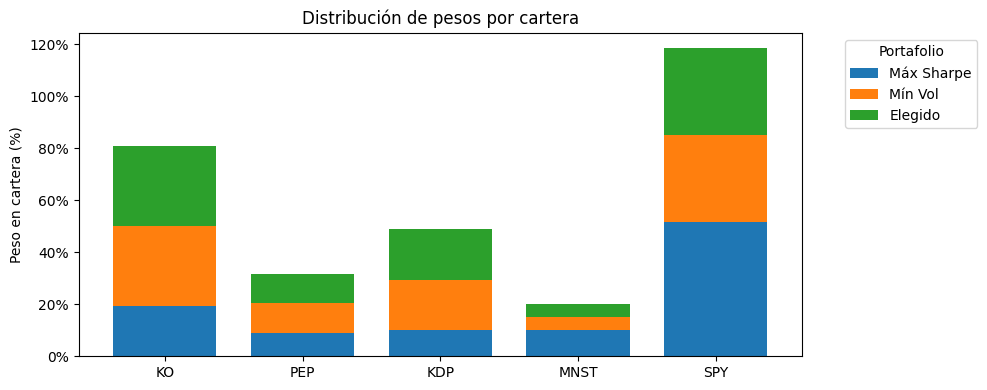


### Mapa Riesgo vs. Retorno


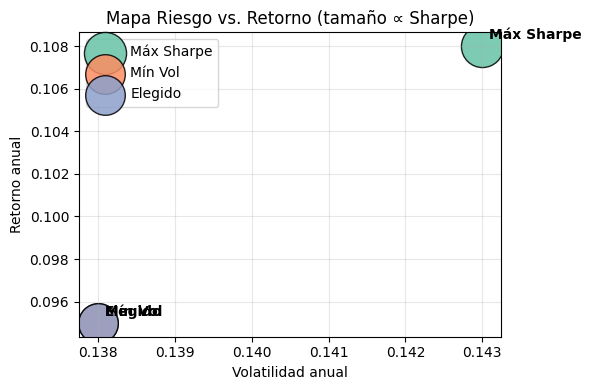

In [ ]:
# ── Funciones de optimización (para asegurar que existan) ────────────────
def simulate_portfolios(ret_df, n_port=20000, rf=0.02,
                        min_w=0.05, max_w=0.40, trans_cost=0.005, seed=42):
    """
    Montecarlo sencillo para generar carteras aleatorias y métricas clave.
    Retorna un DataFrame con columnas: Return, Vol, Sharpe + pesos por ticker.
    """
    np.random.seed(seed)
    mus = ret_df.mean() * 252
    cov = ret_df.cov() * 252
    names = list(ret_df.columns)
    results = []

    for _ in range(n_port):
        weights = np.random.uniform(min_w, max_w, len(names))
        weights /= weights.sum()

        # Recalcular si las restricciones no se cumplen (opcional, pero mejora la calidad)
        while not all(min_w <= w <= max_w for w in weights):
            weights = np.random.uniform(min_w, max_w, len(names))
            weights /= weights.sum()

        port_ret = mus @ weights - trans_cost
        port_vol = np.sqrt(weights.T @ cov @ weights)
        sharpe = (port_ret - rf) / port_vol
        results.append([port_ret, port_vol, sharpe, *weights])

    cols = ["Return", "Vol", "Sharpe"] + names
    return pd.DataFrame(results, columns=cols)

def efficient_frontier_sim(ret_df, rf=0.02, **mc_kwargs):
    """Calcula la frontera eficiente y los portafolios óptimos."""
    mc = simulate_portfolios(ret_df, **mc_kwargs, rf=rf)
    p_max = mc.loc[mc["Sharpe"].idxmax()]
    p_min = mc.loc[mc["Vol"].idxmin()]
    return mc, p_max, p_min


if __name__ == "__main__":
    try:
        # Definir Tickers y Periodo, si no se han definido antes
        TICKERS_MAIN = ["KO", "PEP", "KDP", "MNST", "SPY"]

        # Obtener datos de precios y calcular retornos
        prices_df = get_historical_data(TICKERS_MAIN, period="5y")
        if prices_df is None:
            exit()

        # Filtramos para no incluir el benchmark en la optimización
        rets = daily_returns(prices_df[[t for t in TICKERS_MAIN if t != "SPY"]])

        # Definir la tasa libre de riesgo
        rf_rate = 0.02

        # ── (re)calcular portafolios si faltan ─────────────────────────────
        # Se asegura de que se calculen los portafolios solo una vez.
        try:
            p_maxSharpe
        except NameError:
            print("↻ Recalculando frontera eficiente…")
            ef, p_maxSharpe, p_minVol = efficient_frontier_sim(rets, rf=rf_rate)

            # **NUEVA LÓGICA:** Encontrar el portafolio con retorno cercano al 8% y mínimo riesgo
            target_return = 0.08
            target_range = 0.005
            filtered_portfolios = ef[(ef['Return'] >= target_return - target_range) &
                                     (ef['Return'] <= target_return + target_range)]

            if not filtered_portfolios.empty:
                target = filtered_portfolios.iloc[filtered_portfolios['Vol'].idxmin()]
            else:
                print(f"⚠️ No se encontraron portafolios con un retorno cercano al {target_return*100:.0f}%. "
                      "Se seleccionará el más cercano.")
                target = ef.iloc[(ef['Return'] - target_return).abs().idxmin()]

            print("✓ Listo.")

        from IPython.display import display
        from matplotlib.ticker import PercentFormatter

        # ── 1) DataFrame comparativo (formato bonito) ──────────────────────
        metric_cols = ["Return", "Vol", "Sharpe"]
        tickers = [c for c in p_maxSharpe.index if c not in metric_cols]

        port_df = pd.DataFrame(
            [p_maxSharpe[metric_cols+tickers],
             p_minVol[metric_cols+tickers],
             target[metric_cols+tickers]],
            index=["Máx Sharpe", "Mín Vol", "Elegido"]
        ).round(3)

        print("### Tabla comparativa de portafolios óptimos")
        display(port_df.style
                .background_gradient(subset=["Sharpe"], cmap="RdYlGn")
                .format("{:.2%}", subset=["Return", "Vol"])
                .format("{:.1%}", subset=tickers))

        # ── 2) Gráfico apilado de pesos ─────────────────────────────────────
        print("\n### Distribución de pesos por cartera")
        fig, ax = plt.subplots(figsize=(10,4))
        (port_df[tickers].T * 100).plot(kind="bar", stacked=True, ax=ax, width=0.75)
        ax.set_ylabel("Peso en cartera (%)")
        ax.yaxis.set_major_formatter(PercentFormatter())
        ax.set_title("Distribución de pesos por cartera")
        ax.legend(title="Portafolio", bbox_to_anchor=(1.05,1), loc="upper left")
        plt.xticks(rotation=0); plt.tight_layout(); plt.show()

        # ── 3) Diagrama de burbujas riesgo–retorno ─────────────────────────
        print("\n### Mapa Riesgo vs. Retorno")
        fig, ax = plt.subplots(figsize=(6,4))
        colors = dict(zip(port_df.index, sns.color_palette("Set2", 3)))
        for lbl, row in port_df.iterrows():
            ax.scatter(row["Vol"], row["Return"], s=row["Sharpe"]*1500,
                        color=colors[lbl], alpha=0.85, edgecolor="k", label=lbl)
            ax.annotate(lbl, (row["Vol"], row["Return"]), xytext=(5,5),
                        textcoords="offset points", weight="bold")
        ax.set_xlabel("Volatilidad anual"); ax.set_ylabel("Retorno anual")
        ax.set_title("Mapa Riesgo vs. Retorno (tamaño ∝ Sharpe)")
        ax.grid(alpha=.3); ax.legend(); plt.tight_layout(); plt.show()

    except Exception as e:
        print(f"Ocurrió un error durante la ejecución: {e}")